In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Downloading CSV file from Yahoo Finance on BTC Prices

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1JbrxeSqazKn-WjizVDPG9VvhkXVG--D-'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('BTC-USD.csv')


In [ ]:
# Create pandas dataframe
data = pd.read_csv('BTC-USD.csv')

In [ ]:
# Plot data.head()
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


Let's plot the bitcoin price. I make a plot of bitcoin price vs the days after September 15, 2014, the start date of this dataset. Day "0" indicates September 15, 2014.

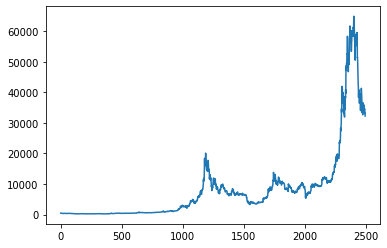

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting

g = sns.lineplot(x = np.linspace(1,2495,2495), y = data['High'].values.reshape(-1))


Next, we plot bitcoin vs. days. But this time there are dates added to the graph.

[Text(0, 0, '2014-09-17'),
 Text(0, 0, '2015-04-05'),
 Text(0, 0, '2015-10-22'),
 Text(0, 0, '2016-05-09'),
 Text(0, 0, '2016-11-25'),
 Text(0, 0, '2017-06-13'),
 Text(0, 0, '2017-12-30'),
 Text(0, 0, '2018-07-18'),
 Text(0, 0, '2019-02-03'),
 Text(0, 0, '2019-08-22'),
 Text(0, 0, '2020-03-09'),
 Text(0, 0, '2020-09-25'),
 Text(0, 0, '2021-04-13')]

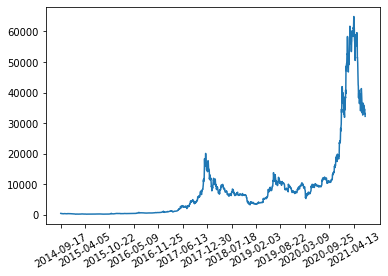

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns # Used for plotting
g = sns.lineplot(x = np.linspace(1,2495,2495), y = data['High'].values.reshape(-1))
#g.map(plt.plot, "a", "v", marker="o")
g.set(xticks=np.arange(0,2500,200))
g.set_xticklabels(rotation=30, labels = data['Date'][0::200])

Data preprocessing

In [ ]:
# Create a dataframe that only contains High Column.
data.dropna()
data_high = pd.DataFrame(data, columns = ['High'])
data_high = data_high.to_numpy()
print(data_high)

[[  468.174011]
 [  456.859985]
 [  427.834991]
 ...
 [33061.398438]
 [33159.640625]
 [32218.40625 ]]



Used MinMaxScaler to scale the data for my use.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data_normalized = scaler.fit_transform(data_high) 
print(data_high.shape)

(2495, 1)


In [ ]:

def create_dataset(dataset, time_steps=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [ ]:
# Chose the number of time steps that the model "looks back"
time_steps = 4

# Produced my dataset based on the number of days the model could look back
X, y = create_dataset(data_normalized, time_steps=time_steps)
#X = np.reshape(X, (2490, 4))
#y = np.reshape(y, (2490,))



Split data into train and test sets. Use 80\% for training and 20\% for testing.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0, shuffle=False)

In [ ]:
# Reshaped input to be [samples, time steps, features].
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
print(X_train.shape, X_test.shape)

(1992, 1, 4) (498, 1, 4)


Compile my RNN model and display the summary:

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM
print(X_train.shape, y_train.shape)
input_layer = Input(shape=(1,4))
x = LSTM(64)(input_layer) 
print(x.shape)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.8)(x)
x = Dense(32, activation='relu')(x)

x = Dense(1, activation='linear')(x)
model = Model(input_layer, x)

model.compile(loss = 'mean_squared_error',
              optimizer = tf.keras.optimizers.Adam(2e-4),
              metrics = 'mean_squared_error')

(1992, 1, 4) (1992, 1)
(None, 64)


In [ ]:

batch_size = 256

epochs = 15 

# Fit model
history = model.fit(X_train, y_train, batch_size, epochs, validation_split=0.2, shuffle=True)

Epoch 1/15
7/7 [==============================] - 3s 94ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 2/15
7/7 [==============================] - 0s 10ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0131 - val_mean_squared_error: 0.0131
Epoch 3/15
7/7 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 4/15
7/7 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 5/15
7/7 [==============================] - 0s 10ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 6/15
7/7 [==============================] - 0s 12ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 7/15
7/7 [==============================] 

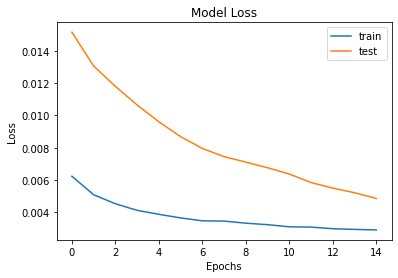

In [ ]:
# Plot the Model loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


More Advanced RNN Model

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, LSTM, GRU
print(X_train.shape, y_train.shape)
input_layer = Input(shape=(1,4))
#x = Embedding(data_high.size, 64)(input_layer)
#print(x.shape)
x = GRU(64)(input_layer) 
print(x.shape)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)


x = Dense(1, activation='linear')(x)
model = Model(input_layer, x)

model.compile(loss = 'mean_squared_error',
              optimizer = tf.keras.optimizers.Adam(2e-4),
              metrics = 'mean_squared_error')


(1992, 1, 4) (1992, 1)
(None, 64)


In [ ]:

batch_size = 256

epochs = 15 

# Fit model
history = model.fit(X_train, y_train, batch_size, epochs, validation_split=0.2, shuffle=True)

Epoch 1/15
7/7 [==============================] - 3s 82ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 2/15
7/7 [==============================] - 0s 8ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 3/15
7/7 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0052 - val_mean_squared_error: 0.0052
Epoch 4/15
7/7 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 5/15
7/7 [==============================] - 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 6/15
7/7 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 7/15
7/7 [==============================] - 0

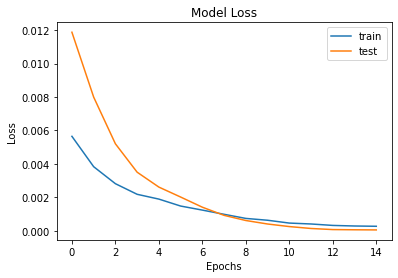

In [ ]:
# Plot the Model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Looking at the Predictions...

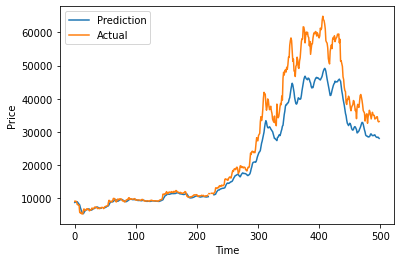

In [ ]:
#scaler.fit_transform(data_high.reshape(-1, 1))

predict = model.predict(X_test)
predict = scaler.inverse_transform(predict)
test = scaler.inverse_transform(y_test.reshape(-1,1))

np.concatenate((predict.reshape(len(predict),1), test.reshape(len(test),1)),1 )
plt.plot(np.linspace(0,498,num=predict.shape[0]), predict)
plt.plot(np.linspace(0,498,num=test.shape[0]),test)
plt.ylabel('Price')
plt.xlabel('Time')
plt.legend(['Prediction', 'Actual'])
plt.show()
